In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.client import device_lib

config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 

tf.keras.backend.set_session(sess)

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

## Analysis of the dataset

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = x_train.shape[1:]
num_classes = np.unique(y_train).shape[0]

print("number of classes:", num_classes)
print("input shape:", input_shape)
print("Image data type:", x_train.dtype)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
number of classes: 10
input shape: (32, 32, 3)
Image data type: uint8


The dataset consists of 60000 images of size 32x32 pixels. The images are rgb (3 channels). There are 10 classes in the dataset.

### Visualisation of the dataset

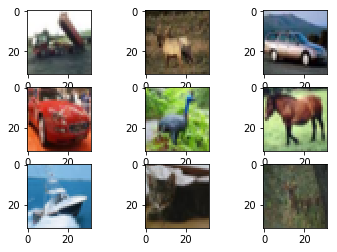

In [15]:
for row in range(3):
    for col in range(3):
        idx = row * 3 + col + 1
        plt.subplot(3,3, idx)
        plt.imshow(x_train[idx + 1])

(50000, 1)


<BarContainer object of 10 artists>

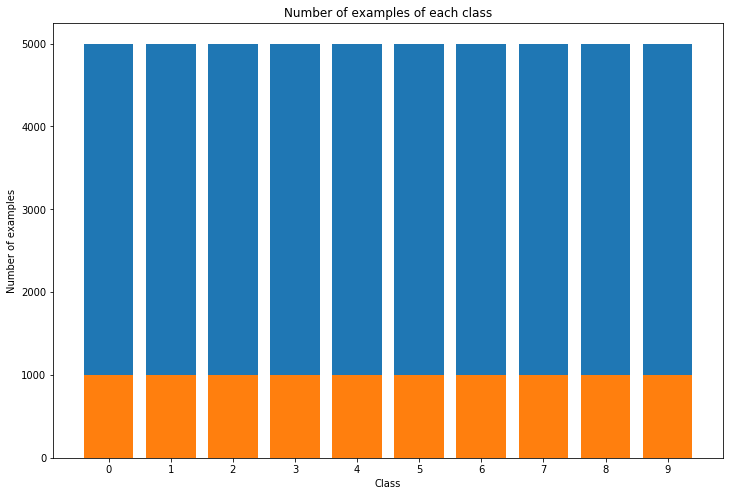

In [16]:
print(y_train.shape)
class_distribution_train = Counter(y_train[:,0])
class_distribution_test = Counter(y_test[:,0])
x = range(10)
train_y = [class_distribution_train[cls] for cls in x]
test_y = [class_distribution_test[cls] for cls in x]
plt.figure(figsize=(12,8))
plt.xticks(x)
plt.title("Number of examples of each class")
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.bar(x, train_y)
plt.bar(x, test_y)

The dataset is evenly distributed across the 10 classes.

### Normalize the dataset

In [17]:
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Split out validation data

In [18]:
train_val_split = 0.85 # Percentage of data to use in training set
indexes = np.arange(x_train.shape[0])
np.random.shuffle(indexes)
# Select random indexes for train/val set
idx_train = indexes[:int(train_val_split * x_train.shape[0])]
idx_val = indexes[int(train_val_split * x_train.shape[0]):]

x_val_data = x_train[idx_val]
y_val_data = y_train[idx_val]

x_train_data = x_train[idx_train]
y_train_data = y_train[idx_train]

print("Training images:", x_train_data.shape)
print("Validation images:", x_val_data.shape)
print("Test images:", x_test.shape)

Training images: (42500, 32, 32, 3)
Validation images: (7500, 32, 32, 3)
Test images: (10000, 32, 32, 3)


## Model definition

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=input_shape))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
model.add(tf.keras.layers.Activation('relu'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(num_classes))
model.add(tf.keras.layers.Activation('softmax'))

### Training the model

In [20]:
batch_size = 32
epochs = 10

In [21]:
opt = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
opt = 'adam'

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
model.fit(x_train_data, y_train_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val_data, y_val_data),
          shuffle=True)

Train on 42500 samples, validate on 7500 samples
Epoch 1/10
42500/42500 [==============================] - 20s 461us/step - loss: 1.3764 - acc: 0.5114 - val_loss: 1.1661 - val_acc: 0.5904
Epoch 2/10
42500/42500 [==============================] - 19s 449us/step - loss: 0.9847 - acc: 0.6552 - val_loss: 1.0298 - val_acc: 0.6423
Epoch 3/10
42500/42500 [==============================] - 19s 451us/step - loss: 0.7845 - acc: 0.7268 - val_loss: 1.0598 - val_acc: 0.6387
Epoch 4/10
42500/42500 [==============================] - 19s 450us/step - loss: 0.6076 - acc: 0.7895 - val_loss: 1.0890 - val_acc: 0.6480
Epoch 5/10
42500/42500 [==============================] - 19s 451us/step - loss: 0.4427 - acc: 0.8471 - val_loss: 1.2526 - val_acc: 0.6291
Epoch 6/10
42500/42500 [==============================] - 19s 452us/step - loss: 0.2990 - acc: 0.8980 - val_loss: 1.4707 - val_acc: 0.6169
Epoch 7/10
42500/42500 [==============================] - 19s 453us/step - loss: 0.2011 - acc: 0.9320 - val_loss: 1.7

In [23]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 115us/step
Test loss: 2.3171846996307375
Test accuracy: 0.6107
